In [394]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn import linear_model
import datetime
from itertools import product
import statsmodels.api as sm
import warnings
from sklearn import preprocessing

%matplotlib inline

In [246]:
def regression(res, alpha = 0.1, plot = False,verbose = False):
    X = res.drop('trip_count',axis = 1);
    if verbose:
        print 'X shape is', X.shape
        
    y = res.loc[:,'trip_count'];
    lassoReg = linear_model.Lasso(alpha = alpha, max_iter = 1e5,fit_intercept = True,random_state = 0);
    lassoReg.fit(X,y)
    y_pr = pd.Series(data = lassoReg.predict(X), index = res.index)
    R = lassoReg.score(X,y);
    print 'R factor is ', R
    
    if plot:
        plt.figure(figsize = [15,10])
        plt.subplot(211)
        plt.plot(y)
        plt.plot(y_pr)
        plt.legend(['Original data','Predicted'])

        plt.subplot(212)
        plt.plot(y-y_pr)
        plt.legend(['Residuals'])
        
    return [y_pr, y-y_pr, lassoReg]

In [247]:
def addFeatures(res, Kw = 6, Ka = 3,verbose = False):    
    # add linear feature
    res = res.assign(hours = (res.index - datetime.datetime(2014,1,1,0,0,0))/np.timedelta64(1, 'h'))
    
    # добавляем гармонические фичи
    for ind in range(1,Kw+1):
        res['weekCos'+str(ind)]= np.cos(np.pi*res.hours*ind/168);
        res['weekSin'+str(ind)]= np.sin(np.pi*res.hours*ind/168);
    for ind in range(1,Ka+1):
        res['yearCos'+str(ind)]= np.cos(2*np.pi*res.hours*ind/8766);
        res['yearSin'+str(ind)]= np.sin(2*np.pi*res.hours*ind/8766);
        
    # добавляем dummy variables для дней недели
    lbDays = preprocessing.LabelBinarizer()
    lbDays.fit(list(np.arange(6)))
    DoW = pd.DataFrame(lbDays.transform(res.index.dayofweek),columns = ['DayOfWeek_'+str(x) for x in np.arange(6)],
                       index = res.index)      
    res = res.merge(DoW,left_index=True,right_index=True)
 
    # добавляем dummy variables для месяца
    lbMonths = preprocessing.LabelBinarizer()
    lbMonths.fit(list(np.arange(12)))
    Months = pd.DataFrame(lbMonths.transform(res.index.month),columns = ['Month_'+str(x) for x in np.arange(12)],index = res.index)      
    res = res.merge(Months,left_index=True,right_index=True);
    return res

In [239]:
# id нужных регионов
regsDf = pd.read_csv('../crowdRegs.csv',names=['id','regId']);  

# временные ряды для этих регионов
df = pd.read_pickle('../crowdRegs2.pcl')
df.columns = regsDf.regId.values.astype('str')

# словарь с группировкой рядов
tsGroups = np.load('tsGroups.npy').item()

# словарь с оптимальными параметрами для каждой группы
paramsGroups = np.load('paramsGroups.npy').item()

*Логика скрипта:*
<ol>
<li> Выбираем одну группу
<li> В группе выбираем один ряд
<li> По номеру группы подгружаем оптимальные параметры
<li> Обучаем регрессор
<li> Обучаем SARIMAX модель
<li> Сохраняем модель (??? Может быть без данных, чтобы сэкономить место).
<li> Делаем предсказание
<li> Сохраняем предсказение
<li> Идём на второй или первый шаг
<ol>
    

In [17]:
# тестируем процедуру на одном ряду. Например, группа gr0, ряд 1283

In [40]:
startDate = '2016-01-01 0:0:0'
endDate = '2016-04-30 23:59:59'

In [248]:
grId = 'gr0'
tsId = '1283'

# получаем параметры
params = paramsGroups.get(grId)[1] 

# получаем временной ряд
ts = df.loc[startDate:endDate,tsId] #

# обучаем регрессор
ts = ts.to_frame(name = 'trip_count')
[r_pr, res, regressor] = regression(addFeatures(ts),verbose = True)

try:
    mSARIMA=sm.tsa.statespace.SARIMAX(ts, order=[params[0], 1, params[1]],seasonal_order=(params[2], 1, params[3], 24),
                                      exog = r_pr, enforce_invertibility = True).fit(disp=1);
except Exception as inst:
    print type(inst)     
    print inst           

X shape is (2904, 37)
R factor is  0.0585646947585


In [249]:
pr = mSARIMA.predict()
pr[pr<0] = 0

(735995.0, 736022.0)

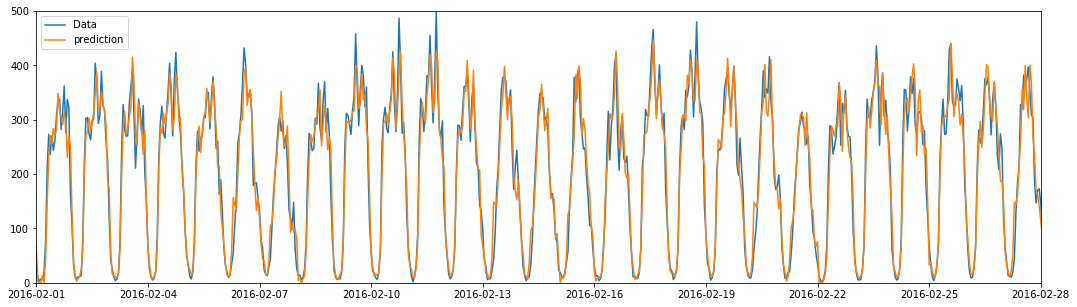

In [250]:
plt.figure(figsize = [18,5])
plt.plot(ts)
plt.plot(pr)
plt.legend(['Data','prediction'])
plt.ylim([0, 500])
plt.xlim(['2016-02-01','2016-02-28'])

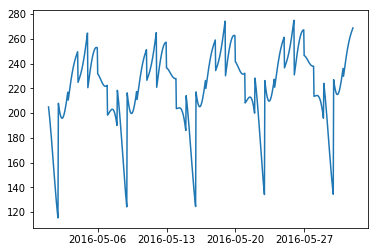

In [315]:
t =  datetime.datetime(2016,4,30,23) 
predictionStart = t + datetime.timedelta(hours=1)
predictionEnd = t + datetime.timedelta(days=31)
date_index = pd.date_range(predictionStart, predictionEnd, freq='H')

#какой-то пипец. Должен быть способ сделать это проще.
features = date_index.to_series().to_frame()

features = addFeatures(features,verbose = True)
features = features.drop(0,axis = 1)
r_pr2 = np.expand_dims(regressor.predict(features),axis = 1)
plt.plot(features.index,r_pr2)

In [316]:
r_pr3 = mSARIMA.get_prediction(start= '2016-04-30 23:00', end= predictionEnd, dynamic=True, exog=r_pr2)
r_pr4 = mSARIMA.get_prediction(start= '2016-04-30 23:00', end= predictionEnd, dynamic=False, exog=r_pr2)

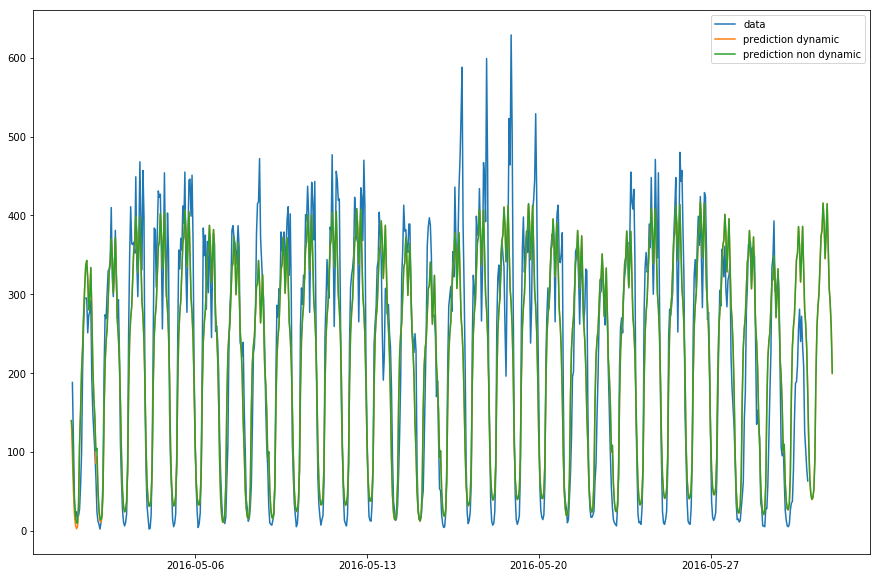

In [317]:
plt.figure(figsize=[15,10])
plt.plot(df.loc[predictionStart:predictionEnd,tsId])
plt.plot(r_pr3.predicted_mean)
plt.plot(r_pr4.predicted_mean)

plt.legend(['data','prediction dynamic','prediction non dynamic'])

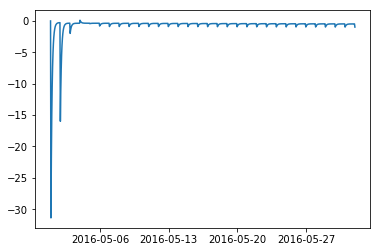

In [318]:
plt.plot(r_pr3.predicted_mean-r_pr4.predicted_mean)

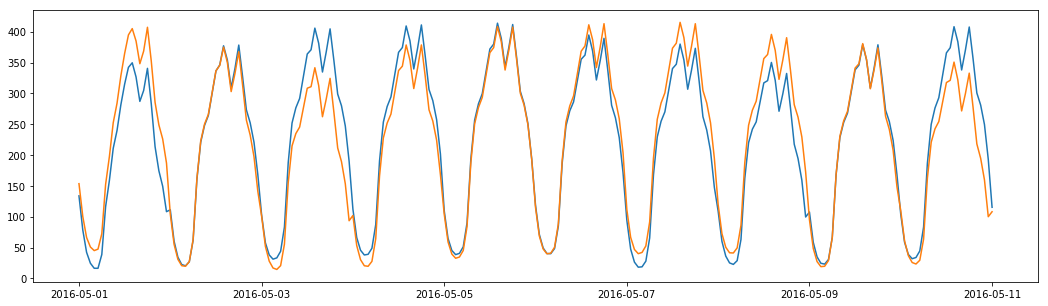

In [428]:
t =  datetime.datetime(2016,5,15)

def predict(SARIMA, regressor, start_date = '2016-05-15 00:00:00', end_date = '2016-05-20 23:00:00'):
    predictionStart = datetime.datetime.strptime(start_date,'%Y-%m-%d %H:%M:%S')
    predictionEnd = datetime.datetime.strptime(end_date,'%Y-%m-%d %H:%M:%S')
    date_index = pd.date_range(predictionStart, predictionEnd, freq='H')
   
    #какой-то пипец. Должен быть способ сделать это проще.
    features = date_index.to_series().to_frame()
    features = addFeatures(features,verbose = True)
    features = features.drop(0,axis = 1)
    exog = np.expand_dims(regressor.predict(features),axis = 1)
    predict = mSARIMA.forecast(exog=exog,dynamic = False,startDate = predictionStart,endDate = predictionEnd,
                               steps = exog.shape[0])
    return predict

pr1 = predict(mSARIMA,regressor,start_date ='2016-05-15 0:0:0',end_date = '2016-05-25 0:0:0')
pr2 = predict(mSARIMA,regressor,start_date ='2016-04-15 0:0:0',end_date = '2016-04-25 0:0:0')
    

plt.figure(figsize = [18,5])
#plt.plot(df.loc[predictionStart:predictionEnd,tsId].values)
plt.plot(pr1.index,pr1.values)
plt.plot(pr2.index,pr2.values)

In [405]:
start_date = '2016-05-15 00:00:00'
datetime.datetime.strptime(start_date,'%Y-%m-%d %H:%M:%S')

datetime.datetime(2016, 5, 15, 0, 0)

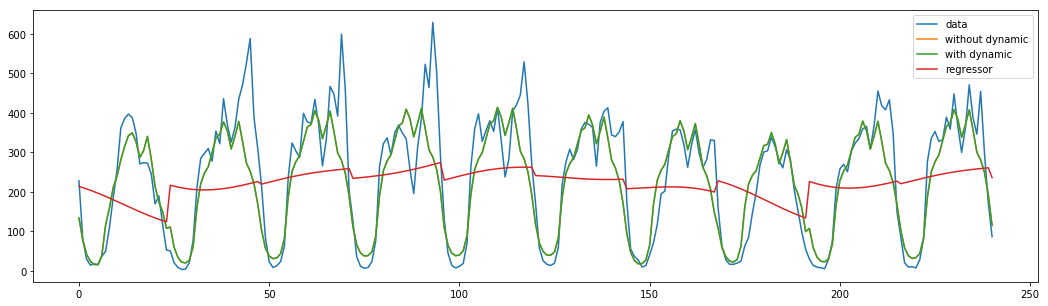

In [430]:
t =  datetime.datetime(2016,5,15) 
predictionStart = t + datetime.timedelta(hours=0)
predictionEnd = t + datetime.timedelta(days = 10)
date_index = pd.date_range(predictionStart, predictionEnd, freq='H')

#какой-то пипец. Должен быть способ сделать это проще.
features = date_index.to_series().to_frame()

features = addFeatures(features,verbose = True)
features = features.drop(0,axis = 1)
r_pr2 = np.expand_dims(regressor.predict(features),axis = 1)


plt.figure(figsize = [18,5])
plt.plot(df.loc[predictionStart:predictionEnd,tsId].values)
plt.plot(mSARIMA.forecast(exog=r_pr2,dynamic = True,startDate = predictionStart,
                          endDate = predictionEnd,steps = r_pr2.shape[0]).values)
plt.plot(mSARIMA.forecast(exog=r_pr2,dynamic = True,startDate = predictionStart,
                          endDate = predictionEnd,steps = r_pr2.shape[0]).values)
plt.plot(r_pr2)
plt.legend(['data','without dynamic','with dynamic','regressor'])